# Initialisation and Utility Functions

This notebook can perform three different types of exports and loads:-

1. Extract and Load of OSM Railway geodata
2. Extract and Load of OSM Historical Railway geodata
3. Extract and Load of Google Maps Railway route geodata

The workbook commences with initialisation of imports and global variables, and two utility functions

In [7]:
import configparser
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import webbrowser
from sqlalchemy import create_engine


DATA_DIR = os.path.join('D:\\Data\\TPAM\\')
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [8]:
def create_folium_map(routes_to_map):
    m = folium.Map(location=[52.48, 0], zoom_start= 7, tiles='cartodbpositron')
    folium.GeoJson(data=routes_to_map["geometry"]).add_to(m)
    m.save('temporary_map.html')
    webbrowser.open('temporary_map.html', new=2)
    return

In [9]:
def print_df_info(df):
    #routes.to_csv('df.csv', index=False)
    print(type(df))
    print(df.head())
    print(df.crs)
    print(df.total_bounds)
    print(df.info())
    df.plot(figsize=(6, 6))
    plt.show()
    return

# Open Historical Maps Import

First execute the following manual activities outside of the workbook:-
1. Go to (Overpass Turbo)[https://openhistoricalmap.github.io/overpass-turbo/] and export railway route data via the wizard with route=train
2. Rename the downloaded file as "osmhistory_railroutes.geojson" and move it to the DATA_DIR

In [10]:

osmhistory_railroutes = gpd.read_file(DATA_DIR + "osmhistory_railroutes.geojson")

In [11]:

config = configparser.ConfigParser()
KEYS_DIR = os.path.join("D:\\Data", "API_Keys")
config.read(os.path.join(KEYS_DIR, "TPAMWeb.ini"))
db_pswd = config['MySQL']['p']
engine = create_engine('postgresql://postgres:' + db_pswd + '@localhost/TPAM')


If rerunning this load then first do the following outside of the notebook:-
1. Go to the Django TPAM and:-
    a. Comment out the existing model LocationsRoutesGeoOsmhistory in models.py
    b. Comment out the admin entry for the model LocationsRoutesGeoOsmhistory
    c. Run python manage.py make migrations
    d. Run python manage.py migrate
2. Go to the Database Admin tool (e.g. PgAdmin) and drop the existing table "locations_routes_geo_osmhistory"

Now load the databse table with the following command

<class 'geopandas.geodataframe.GeoDataFrame'>
                 id               @id building layer  \
0  relation/2693956  relation/2693956      yes     1   
1  relation/2693958  relation/2693958      yes  None   
2  relation/2693959  relation/2693959      yes  None   
3  relation/2693960  relation/2693960      yes    -1   
4     way/198163527     way/198163527      yes  None   

                                   name public_transport  railway  start_date  \
0            St Pancras Railway Station          station  station  1868-10-01   
1  St Pancras Railway Station Extension          station  station        2007   
2                          King's Cross          station  station        1852   
3                     London Paddington          station  station        1838   
4                            Wagon Lift             None  station        1854   

  train          type  ... name:1886-1937 name:1937- source:data  \
0   yes  multipolygon  ...           None       None        No

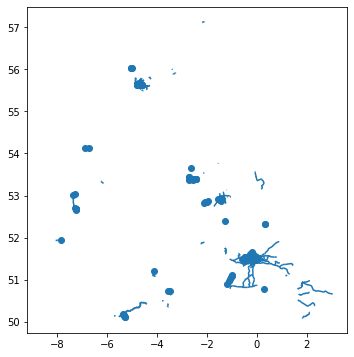

In [12]:
routes = gpd.read_file(DATA_DIR + "osmhistory_railroutes.geojson")
routes.to_postgis(name="locations_routes_geo_osmhistory", if_exists='append', index=False, con=engine)
create_folium_map(routes)
# print_df_info(routes)

## Post Load Actions
Go to the Terminal command line in the TPAM Django project and generate the Django table model from the loaded database table:-

python manage.py inspectdb > models_temporary.py

If rerunning the load:-

1. Uncomment out the existing model LocationsRoutesGeoOsmhistory in models.py and adjust for any differences for the table shown in models_temporary.py (osmhistory users may have added new fields which means the existing model Django table definition may not work)
2. Uncomment out the admin entry for the model LocationsRoutesGeoOsmhistory

Else if running the load for the first time:-
1. Copy the model LocationsRoutesGeoOsmhistory from models_temporary.py into models.py
2. Convert the id field to null=False, primary_key=True 
(note the id field already exists in the loaded data but contains characters and therefore cannot be used as the models key)

### OpenStreetMaps Railway Data

The same process as for OpenHistoricalStreetMaps can be used.

In [4]:
routes = gpd.read_file(DATA_DIR + "osm_railroutes.geojson")
routes.to_postgis(name="locations_routes_geo_osm", if_exists='append', index=False, con=engine)
create_folium_map(routes)
print_df_info(routes)

NameError: name 'create_folium_map' is not defined

### Closed UK Railways - from Google Maps
Data download from a map [created by a contributor on Google maps](https://www.google.com/maps/d/viewer?ie=UTF8&oe=UTF8&msa=0&mid=1-qtKdwA-_7Y1msH5nlUbVKMjdMk&ll=51.17557904660408%2C-0.34163366478264123&z=9)
Note that in Postgres/Django the column "Name" has been changed to "name". Needs to be changed back temporarily for this load to work.

In [10]:
closed_routes = gpd.read_file(DATA_DIR + "Closed UK Railways.kml", driver='KML')
closed_routes.head()
closed_routes.to_postgis(name="locations_routes_geo_closed", if_exists='append', index=False, con=engine)
# create_folium_map(closed_routes)
# print_df_info(closed_routes)

### Load of Admin Boundaries

In [8]:
admin_boundaries = gpd.read_file("D:\\Data\\UK_Admin_Boundaries\\" + "Counties_and_Unitary_Authorities__December_2019__Boundaries_UK_BFE.shp")
admin_boundaries.to_postgis(name="locations_UK_admin_boundaries", if_exists='append', index=False, con=engine)
# create_folium_map(admin_boundaries)
# print_df_info(admin_boundaries)